# Boletín 1: Evaluación y Selección de Modelos (KNN)

## Importamos las librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')

# Para evitar warnings en algunas gráficas
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})


## Definimos variables globales

In [3]:
# Establecemos esta semilla para eliminar aleatoriedad y obtener siempre los mismos resultados
SEED_VALUE = 1


## Ejercicio 1

En primer lugar, creamos el DataFrame con el conjunto de datos que aparece en el enunciado de este boletín:

In [4]:
df_ejercicio1 = pd.DataFrame(np.array(
    [[0, 3, 2, 1], 
    [3, 0, 3, 0], 
    [0, 3, -1, 0], 
    [3, 0, 0, 1], 
    [1, 2, 1, 1], 
    [2, 1, 0, 0]]), columns=['X1', 'X2', 'X3', 'Y'])
df_ejercicio1


,X1,X2,X3,Y
0,0,3,2,1
1,3,0,3,0
2,0,3,-1,0
3,3,0,0,1
4,1,2,1,1
5,2,1,0,0


Definimos el punto x0 para el que queremos llevar a cabo la predicción de la variable de salida:

In [5]:
x0 = np.array([0,0,0])
x0

array([0, 0, 0])

### Apartado a

**Computar la distancia entre cada observación y el punto de test.**

Para esto lo que haremos es programar una función que calcule la distancia euclidea entre dos puntos en 3 dimensiones:

In [6]:
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1-x2)

# La siguiente función sería calculándolo sin hacer uso de la norma
# def euclidean_distance(x1, x2):
#     return np.sqrt(np.power((x1[0]-x2[0]), 2) + np.power((x1[1]-x2[1]), 2) + np.power((x1[2]-x2[2]), 2))


Y ahora usamos estas funciones para imprimir las distancia entre cada una de las observaciones y el punto de test:

In [7]:
for index, row in df_ejercicio1.iterrows():
    x = np.array([row['X1'], row['X2'], row['X3']])
    print(f"Distancia entre el punto {x} y el punto de test {x0} = {euclidean_distance(x, x0)}")


Distancia entre el punto [0 3 2] y el punto de test [0 0 0] = 3.605551275463989
Distancia entre el punto [3 0 3] y el punto de test [0 0 0] = 4.242640687119285
Distancia entre el punto [ 0  3 -1] y el punto de test [0 0 0] = 3.1622776601683795
Distancia entre el punto [3 0 0] y el punto de test [0 0 0] = 3.0
Distancia entre el punto [1 2 1] y el punto de test [0 0 0] = 2.449489742783178
Distancia entre el punto [2 1 0] y el punto de test [0 0 0] = 2.23606797749979


### Apartado b

**¿Cuál es la predicción para K=1?¿Por qué?**

Definimos el código a mano, sin hacer uso de la librería `slearn` que nos permitirá responder a los dos siguientes apartados:

In [8]:
def predict(x_train, x_test, y_train, k, verbose=True):
    final_output = []
    for i in range(len(x_test)):
        distances = []
        votes = []

        for j in range(len(x_train)):
            distance = euclidean_distance(x_train[j], x_test[i])
            distances.append([distance, j])

        distances.sort()
        distances = distances[0:k]

        for distance, j in distances:
            votes.append(y_train[j])

        values, counts = np.unique(votes, return_counts=True)
        prediction = np.argmax(counts)

        final_output.append(prediction)

        if(verbose):
            print(
                f"La predicción para {x_test[i]} es {prediction} y el/los {k} vecino(s) más cercanos es/son:")
            for distance, j in distances:
                print(
                    f"El vecino {x_train[j]} a una distancia de {distance} con clase {y_train[j]}")

    return final_output


Llamamos a nuestra función `predict` para un valor de K igual a 1:

In [9]:
x_train = df_ejercicio1.loc[:, 'X1':'X3'].to_numpy()
y_train = df_ejercicio1.loc[:, 'Y'].to_numpy()
x_test = np.array([x0])

prediction = predict(x_train=x_train, x_test=x_test, y_train=y_train, k = 1)


La predicción para [0 0 0] es 0 y el/los 1 vecino(s) más cercanos es/son:
El vecino [2 1 0] a una distancia de 2.23606797749979 con clase 0


### Apartado c

In [10]:
prediction = predict(x_train=x_train, x_test=x_test, y_train=y_train, k = 3)


La predicción para [0 0 0] es 1 y el/los 3 vecino(s) más cercanos es/son:
El vecino [2 1 0] a una distancia de 2.23606797749979 con clase 0
El vecino [1 2 1] a una distancia de 2.449489742783178 con clase 1
El vecino [3 0 0] a una distancia de 3.0 con clase 1


## Ejercicio 2

Ahora trabajaremos con el conjunto de datos [Blood Transfusion Service Center](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center).

### Apartado a

**Analiza las características del conjunto de datos: número y tipo de variables de entrada y salida, número de instancias, número de clases y distribución de las mismas, correlación entre las variables, valores perdidos, etc.**

Ahora empezamos con el análisis de las características del conjunto de datos. En primer lugar, leemos los datos del fichero de entrada:

In [11]:
df_blood_transfusion = pd.read_csv('data/bloodTransfusion.data', 
                      delimiter=',',
                      skiprows=1,
                      header=None,
                      names = ["Recency", "Frequency", "Monetary", "Time", "IsMarchDonor"])

Ahora visualizamos las primeras filas para ver el número y tipo de las variables de entrada y salida:

In [12]:
df_blood_transfusion


,Recency,Frequency,Monetary,Time,IsMarchDonor
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


Cada columna de este DataFrame representa la siguiente información:
- **Recency**: el número de meses que han pasado desde la última donación.
- **Frequency**: el número total de donaciones de esta persona.
- **Monetary**: cantidad total de sangre donada en centímetros cúbicos (c.c.).
- **Time**: el número de meses desde la primera donación de esta persona.
- **IsMarchDonor**: la variable a predecir, que nos indica si esta persona donó o no en Marzo de 2007 (1 significa que donó mientras que 0 indica que no donó).


El número de instancias presentes en el DataFrame es el siguiente:

In [13]:
df_blood_transfusion.shape[0]


748

Comprobamos el tipo de dato de cada una de las columnas presentes en el DataFrame:

In [14]:
print('Tipo de dato de cada columna del Dataframe :')
print(df_blood_transfusion.dtypes)


Tipo de dato de cada columna del Dataframe :
Recency         int64
Frequency       int64
Monetary        int64
Time            int64
IsMarchDonor    int64
dtype: object


Como se puede ver, todas las columnas contienen valores enteros. Ahora continuaremos con las gestión de los valores perdidos. En primer lugar comprobaremos si hay alguno en el DataFrame:

In [15]:
print("Número de valores NaN en cada columna:")
df_blood_transfusion.isna().sum()


Número de valores NaN en cada columna:


Recency         0
Frequency       0
Monetary        0
Time            0
IsMarchDonor    0
dtype: int64

Como se puede ver **no** hay valores perdidos en nuestro DataFrame, sin embargo, en caso de que los hubiese se podría solucionar este problema con el siguiente código, aunque debería ejecutarse después de haber dividido los datos en los conjuntos de entrenamiento y de test:

In [16]:
# # Rellenamos los valores faltantes con la media de la columna
# imp = SimpleImputer(missing_values=np.nan, fill_value='mean')
# imp = imp.fit(df_blood_transfusion)
# df_blood_transfusion_prep = imp.transform(df_blood_transfusion)

# # Convertimos de nuevo en DataFrame el array de numpy devuelto
# df_blood_transfusion = pd.DataFrame(df_blood_transfusion_prep,
#                        columns=df_blood_transfusion.columns,
#                        index=df_blood_transfusion.index)

# df_blood_transfusion


Ahora estudiaremos el número de clases y la distribución de las mismas:

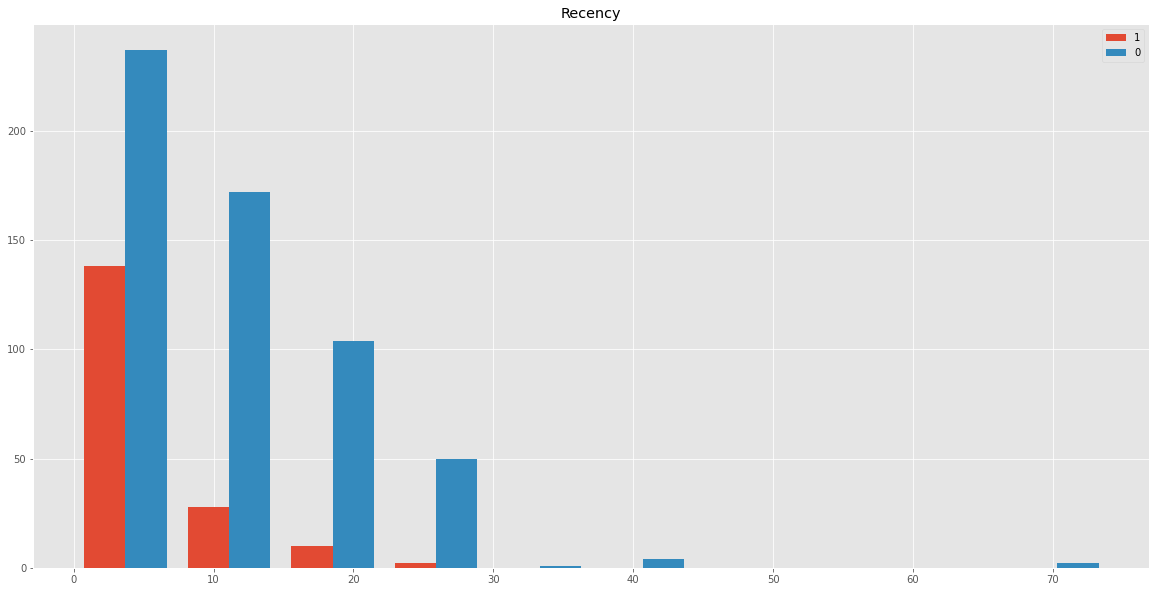

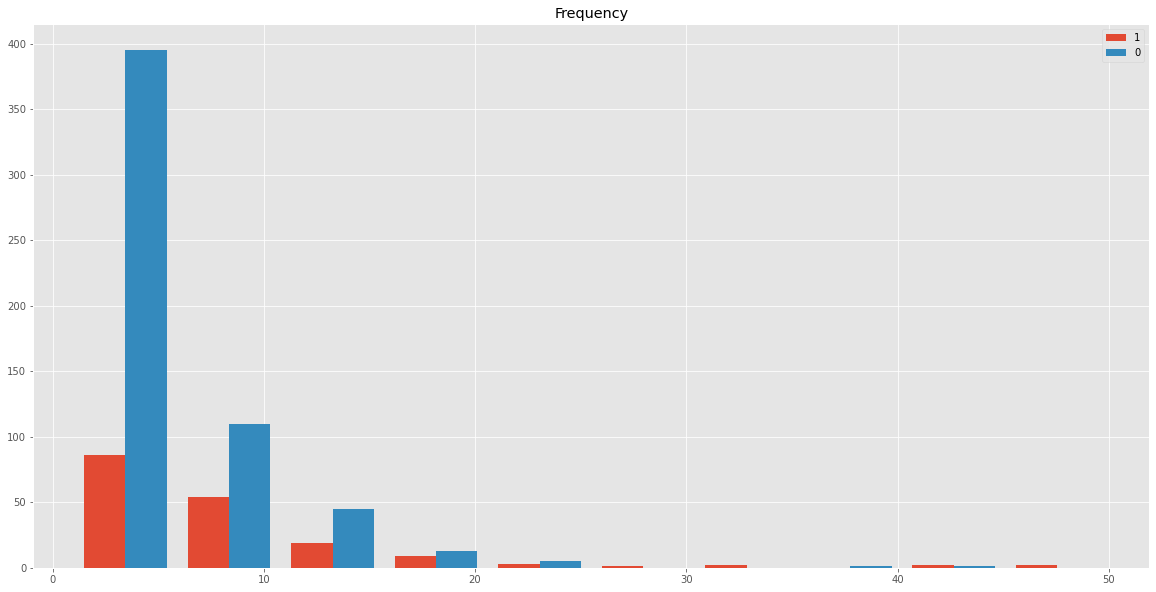

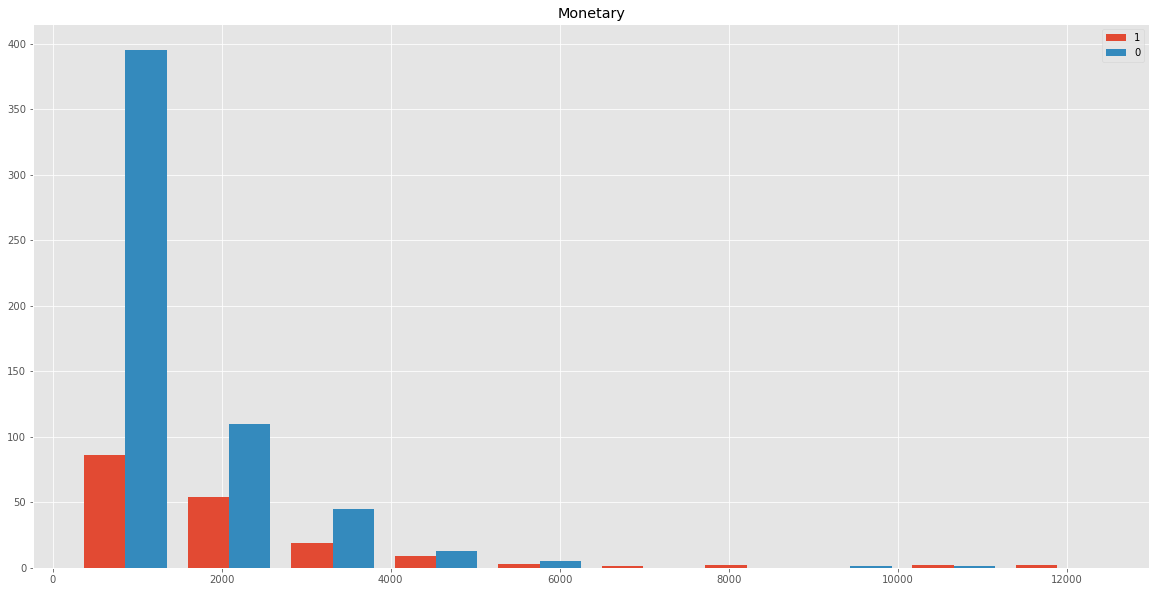

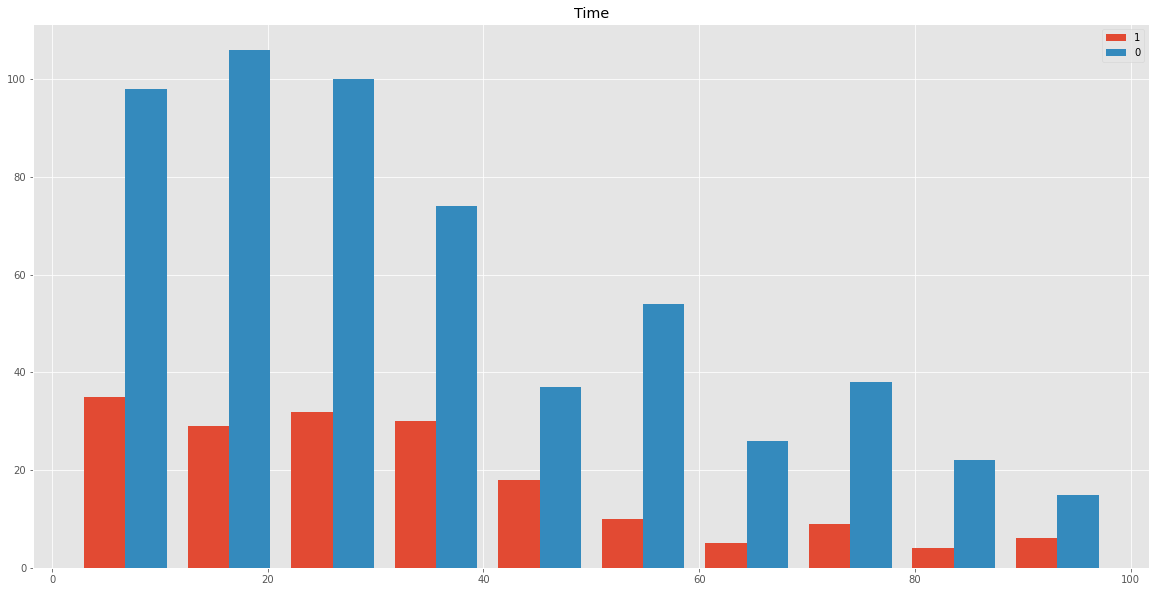

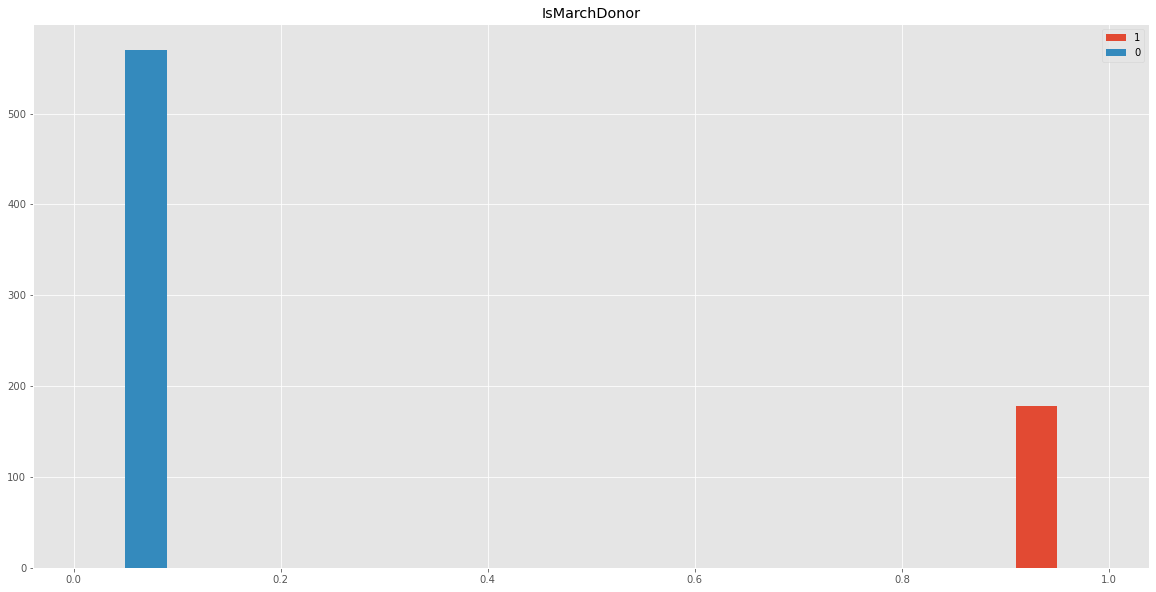

In [17]:
# Visualizamos la distribución de variables por clases
for column in df_blood_transfusion:
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(column)
    ax.hist([df_blood_transfusion[df_blood_transfusion['IsMarchDonor'] == 1][column], df_blood_transfusion[df_blood_transfusion['IsMarchDonor'] == 0][column]], label=['1', '0'])
    ax.legend(loc='upper right')


Como se puede ver, es posible que tengamos un problema en la recolección de los datos ya que hay un número mucho mayor de muestras para la categoría 0 (no donó en Marzo de 2007) que de la categoría 1.

Ahora, para terminar este apartado, comprobaremos la correlación entre las variables:

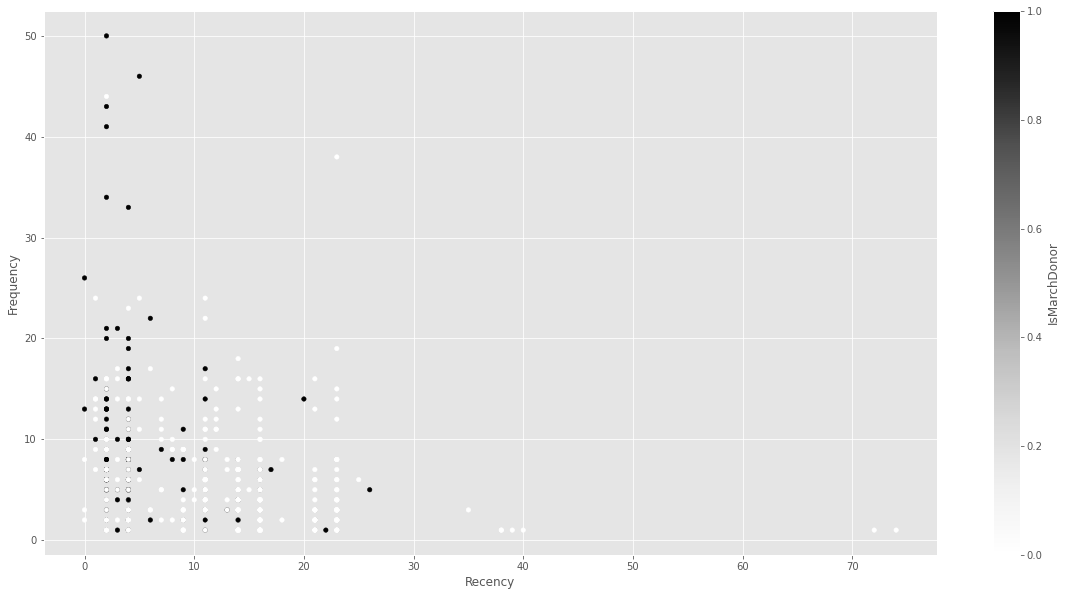

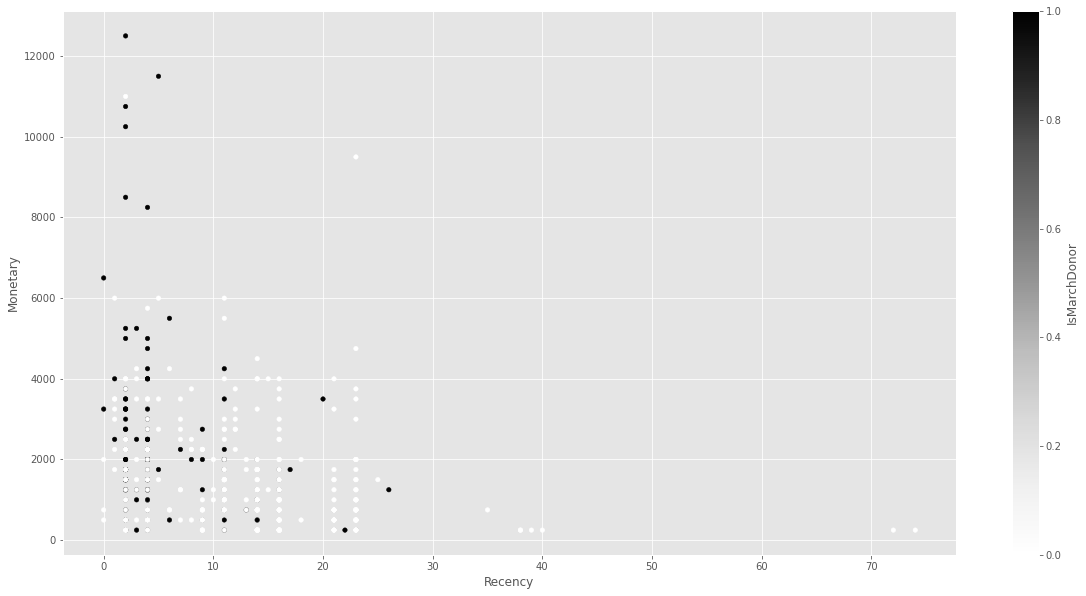

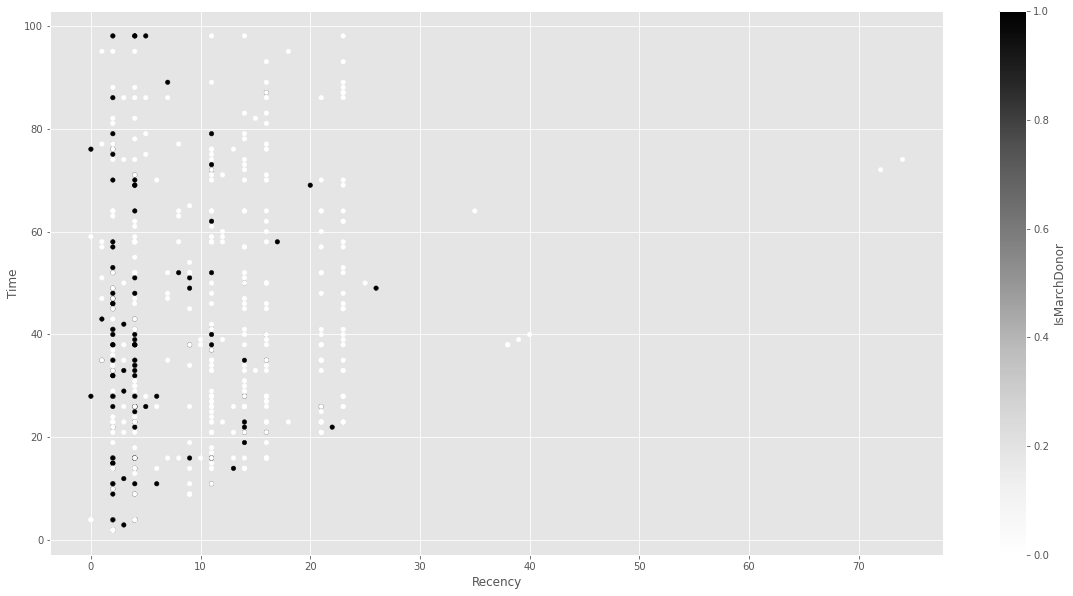

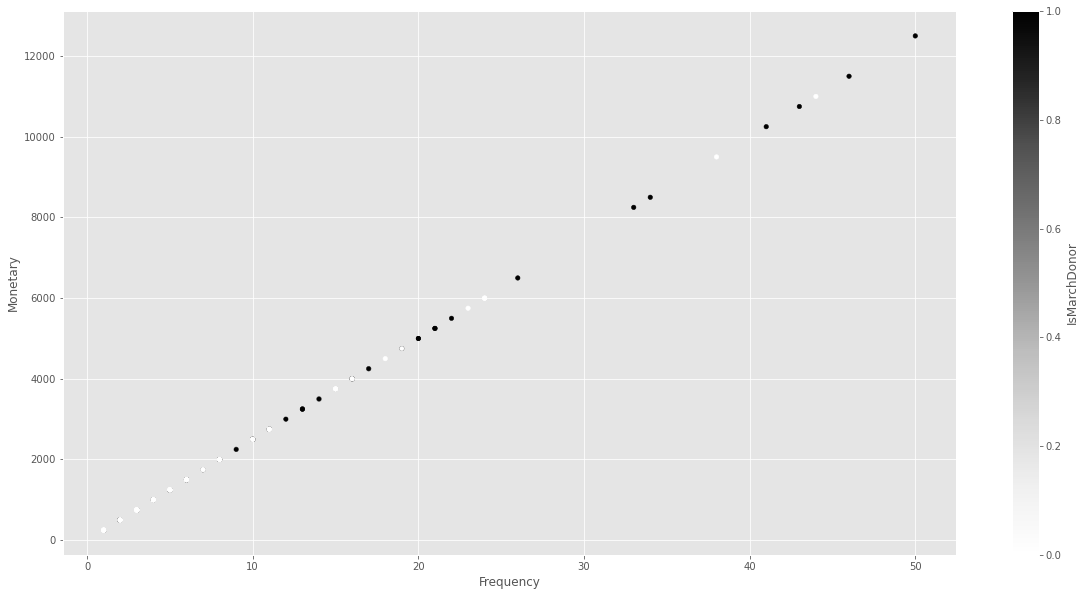

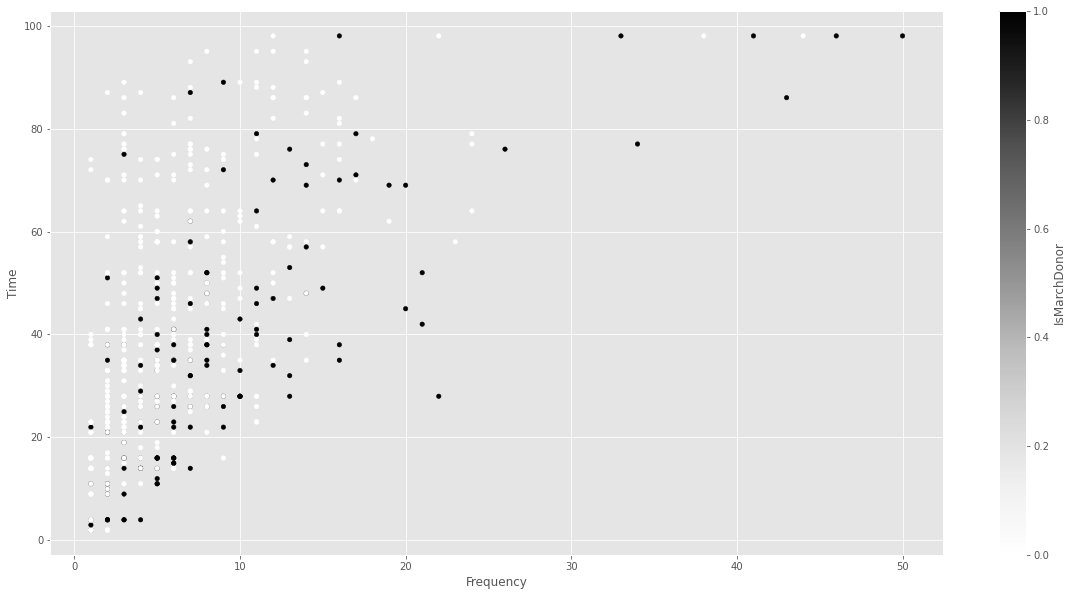

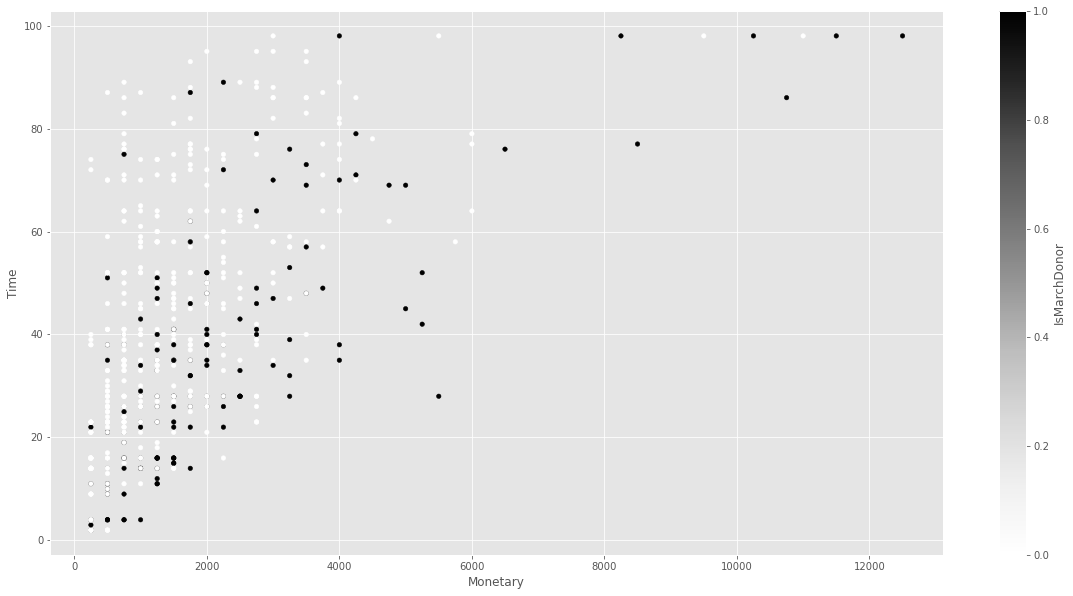

In [18]:
# Omitimos la variable dependiente
column_names = df_blood_transfusion.columns[:-1]

# Ahora representamos atributos por pares (mostrando también la clase)
for i, columna_i in enumerate(column_names):
    for j, columna_j in enumerate(column_names):
        if i < j:
            fig, ax = plt.subplots(figsize=(20,10))
            df_blood_transfusion.plot.scatter(columna_i, columna_j, c='IsMarchDonor', ax=ax)

Como se puede ver, las variables *Frequency* y *Monetary* están directamente relacionadas. Esto tiene sentido ya que si cada vez que se dona se dona la misma cantidad de sangre (en c.c.), el número de veces que se ha donado (*Frequency*) nos dará la información necesaria para saber la cantidad de sangre donada en c.c. (*Monetary*).

Podríamos eliminar alguna de estas dos variables y no debería tener efecto en nuestro modelo, ya que nos indican la misma información.

Por otra parte, también parece haber algún tipo de correlación entre *Time* y *Monetary*, y entre *Time* y *Frequency*.

### Apartado b

**Una de las clases que implementa el algoritmo KNN en `scikit‐learn` es `sklearn.neighbors.KNeighborsClassifier`. Revisa los parámetros y métodos que tiene.**

Se revisa la documentación de la clase `sklearn.neighbors.KNeighborsClassifier` para entender los parámetros que tiene, qué hace cada uno, y los métodos que tiene, y cuál es la función de cada uno.

### Apartado c

**Divide los datos en entrenamiento (80%) y test (20%).**

Dividimos los datos en entrenamiento (80%) y test (20%) mediante este comando:

In [19]:
df_blood_transfusion_train, df_blood_transfusion_test = train_test_split(
    df_blood_transfusion,
    test_size=0.2,
    random_state=SEED_VALUE
)


Comprobamos el tamaño del conjunto de entrenamiento:

In [20]:
df_blood_transfusion_train.shape


(598, 5)

Y el tamaño del conjunto de test:

In [21]:
df_blood_transfusion_test.shape


(150, 5)

### Apartado d

**Realiza la experimentación con KNN (KNeighborsClassifier) usando como hiper‐parámetro el número de vecinos.**

En primer lugar, para llevar a cabo la experimentaxión con KNN es necesario que separemos las variables predictoras y dependientes:

In [22]:
df_blood_transfusion_train_X = df_blood_transfusion_train.loc[:, [
    'Recency', 'Frequency', 'Monetary', 'Time']].astype(float)
df_blood_transfusion_train_Y = df_blood_transfusion_train.loc[:, 'IsMarchDonor']

df_blood_transfusion_test_X = df_blood_transfusion_test.loc[:, [
    'Recency', 'Frequency', 'Monetary', 'Time']].astype(float)
df_blood_transfusion_test_Y = df_blood_transfusion_test.loc[:, 'IsMarchDonor']


Ahora llevamos a cabo la estandarización de los datos. Además, como es un problema de clasificación, **NO** estandarizaremos la variable dependiente.

In [23]:
scaler = StandardScaler()
scaler.fit(df_blood_transfusion_train_X)
df_blood_transfusion_train_X_scaled = scaler.transform(df_blood_transfusion_train_X)
df_blood_transfusion_test_X_scaled = scaler.transform(df_blood_transfusion_test_X)


Los valores con los que se ha estadarizado son los siguientes:

In [24]:
print(f"mean [Recency, Frequency, Monetary, Time]: {scaler.mean_}  |  std [Recency, Frequency, Monetary, Time]: {scaler.scale_}")


mean [Recency, Frequency, Monetary, Time]: [   9.75585284    5.49832776 1374.5819398    34.05351171]  |  std [Recency, Frequency, Monetary, Time]: [   8.33800527    5.79232255 1448.08063804   24.26988333]


Ahora que ya hemos acabado con la visualización y el pre-procesado de los datos, podemos empezar con la experimentación. En primer lugar definimos los hiperparámetros con los que trabjaremos:

In [25]:
hyperparameters = {'n_neighbors': range(1, 101, 1)}


Ahora ejecutamos el entrenamiento:

In [26]:
k_neigh = KNeighborsClassifier()
modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy',
                       return_train_score=True,
                       n_jobs=-1)

# Por como funciona KNN, no haría falta establecer una semilla. Pero lo ponemos igualmente
np.random.seed(SEED_VALUE)

# En KNN no hay aprendizaje en sí, pero hay que ejecutar este comando para poder hacer inferencias
modelCV.fit(df_blood_transfusion_train_X_scaled, df_blood_transfusion_train_Y)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 101)}, return_train_score=True,
             scoring='accuracy')

Ahora podemos consultar los resultados obtenidos, mostrando un ranking con los mejores resultados ordenados de mejor a peor:

In [27]:
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results.loc[:, ['param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score')


,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
18,19,0.795910,0.030314,1
20,21,0.794230,0.029898,2
17,18,0.794202,0.031889,3
24,25,0.792605,0.028075,4
22,23,0.792591,0.028151,5
...,...,...,...,...
73,74,0.764202,0.004022,95
71,72,0.764202,0.004022,95
59,60,0.762535,0.008693,98
2,3,0.744258,0.046403,99


**Muestra la gráfica del error de entrenamiento con validación cruzada (5‐CV) frente al valor del hiper‐parámetro. ¿Cuál es el menor error de validación cruzada, su desviación estándar y el valor del hiper‐parámetro para el que se consigue? ¿Cuál es el valor del hiperparámetro si se aplicase la regla de una desviación estándar?**

Mostramos la gráfica con los resultados del entrenamiento:

<ErrorbarContainer object of 3 artists>

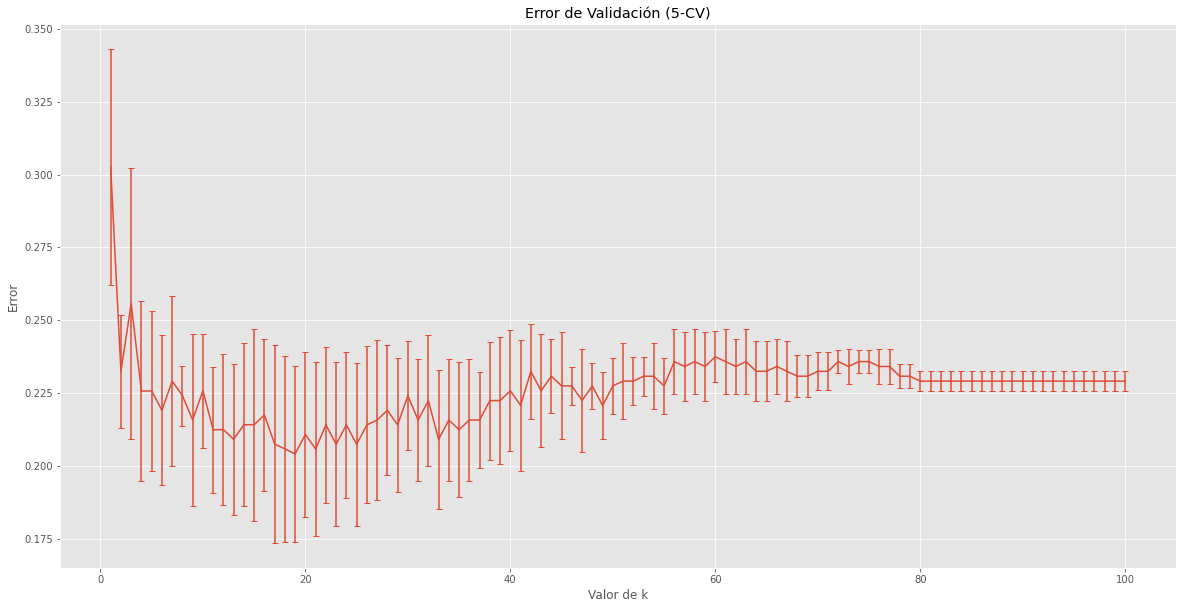

In [28]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de k")
ax.set_ylabel("Error")
ax.errorbar(cv_results['param_n_neighbors'], 1 - cv_results['mean_test_score'], cv_results['std_test_score'], capsize=3)


El menor error de validación cruzada, su desviación estándar y el hiper-parámetro para el que se consigue es el siguiente:

In [29]:
cv_results_best = cv_results.sort_values(by='rank_test_score')
cv_results_best.loc[:, ['param_n_neighbors',
                        'mean_test_score', 
                        'std_test_score', 
                        'rank_test_score'
                        ]
                    ].head(1)


,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
18,19,0.79591,0.030314,1


El valor de `mean_train_score` deberíamos restarle 1 para obtener el error de entrenamiento real:

In [30]:
cv_results_best_error = float(1 - cv_results_best.loc[18, 'mean_test_score'])
cv_results_best_std = float(cv_results_best.loc[18, 'std_test_score'])

# Imprimimos sólo el error por pantalla
cv_results_best_error


0.2040896358543417

Si se aplicase la regla de la desviación estándar, el valor del hiperparámetro escogido sería el siguiente:

In [31]:
cv_results_best_error_plus_std = cv_results_best_error + cv_results_best_std

cv_results_aux = cv_results[
    (1 - cv_results['mean_test_score']) <= cv_results_best_error_plus_std
].sort_values(by='param_n_neighbors', ascending=False)

cv_results_aux = cv_results_aux.loc[:, [
    'param_n_neighbors',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
]

cv_results_aux


,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
99,100,0.770910,0.003533,46
98,99,0.770910,0.003533,46
97,98,0.770910,0.003533,46
96,97,0.770910,0.003533,46
95,96,0.770910,0.003533,46
...,...,...,...,...
6,7,0.770910,0.029284,46
5,6,0.780924,0.025769,26
4,5,0.774272,0.027393,37
3,4,0.774314,0.030884,36


Siendo la gráfica que usamos para decidir los valores de los hiper-parámetros (mediante la regla de una desviación estándar) la siguiente:

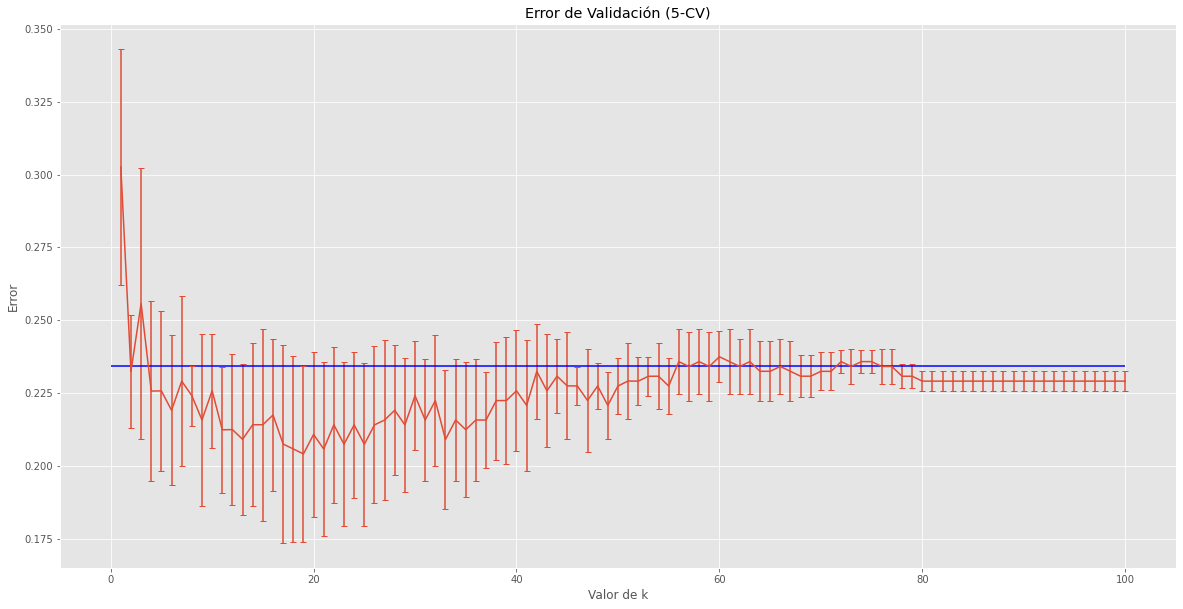

In [32]:
fig, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de k")
ax.set_ylabel("Error")
ax.errorbar(cv_results['param_n_neighbors'],
            1 - cv_results['mean_test_score'],
            cv_results['std_test_score'],
            capsize=3)
ax.hlines(y=cv_results_best_error_plus_std, xmin=0, xmax=100, colors='blue')


El valor que escogeríamos por tanto sería:

In [33]:
cv_results_best_one_std = cv_results_aux.loc[54, [
    'param_n_neighbors',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
]

cv_results_best_one_std


param_n_neighbors          55
mean_test_score      0.772577
std_test_score       0.009657
rank_test_score            41
Name: 54, dtype: object

Con un error de:

In [34]:
cv_results_best_one_std_error = float(1 - cv_results_best_one_std['mean_test_score'])

# Imprimimos el error por pantalla
cv_results_best_one_std_error


0.22742296918767513

**Muestra la gráfica del error de test frente al valor del hiper‐parámetro, y valora si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test. ¿Cuál es el menor error de test y el valor del hiper‐parámetro para el que se consigue? ¿Cuál es el error de test para el valor del hiper‐parámetro seleccionado por la validación cruzada? ¿Cuál es el error de test para el valor del hiper‐parámetro seleccionado por la validación cruzada mediante la regla de una desviación estándar?**

En primer lugar, debemos calcular el error de test frente al valor del hiper-parámetro:

In [35]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(df_blood_transfusion_train_Y) + [0]*len(df_blood_transfusion_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_blood_transfusion_all_X_scaled = np.vstack(
    [df_blood_transfusion_train_X_scaled, df_blood_transfusion_test_X_scaled])
df_blood_transfusion_all_Y = pd.concat(
    [df_blood_transfusion_train_Y, df_blood_transfusion_test_Y])

k_neigh = KNeighborsClassifier()
modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=ps,
                       scoring='accuracy',
                       return_train_score=True,
                       n_jobs=-1)

# Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
np.random.seed(SEED_VALUE)
modelCV.fit(df_blood_transfusion_all_X_scaled, df_blood_transfusion_all_Y)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 101)}, return_train_score=True,
             scoring='accuracy')

Guardamos estos resultados y mostramos por pantalla:

In [36]:
test_results = pd.DataFrame(modelCV.cv_results_)
test_results.loc[:, ['param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score')


,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
19,20,0.806667,0.0,1
20,21,0.800000,0.0,2
24,25,0.800000,0.0,2
16,17,0.800000,0.0,2
31,32,0.800000,0.0,2
...,...,...,...,...
88,89,0.733333,0.0,89
87,88,0.733333,0.0,89
98,99,0.733333,0.0,89
92,93,0.733333,0.0,89


Ahora procedemos a mostrar las gráficas de error de test frente al valor del hiper-parámetro juento con la gráfica con el error de entrenamiento con validación cruzada para ver si este último hizo una buena estimación del error de test:

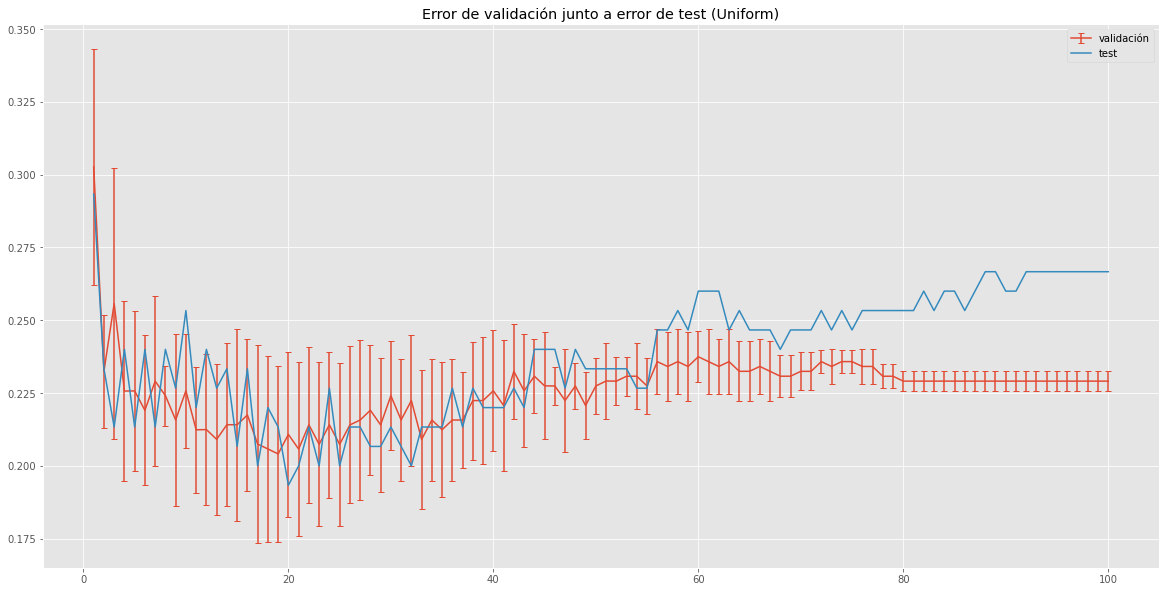

In [37]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Error de validación junto a error de test (Uniform)")
ax.errorbar(cv_results['param_n_neighbors'],
               1 - cv_results['mean_test_score'],
               cv_results['std_test_score'],
               label='validación',
               capsize=3)
ax.errorbar(test_results['param_n_neighbors'],
               1 - test_results['mean_test_score'],
               label='test',
               capsize=3)
ax.legend(loc='upper right')


Como se puede ver, en el caso de usar el hper-parámetro `uniform` la gráfica de error de entrenamiento con validación cruzada sí que hizo una buena estimación de test, mientras que en el vaso del hiper-parámetro `distance` el error de test es menor que el error de entrenamiento con validación cruzada para la mayoría de las combinaciones de los hiper-parámetros.

El menor error de test se consigue para los siguientes valores de los hiper-parámetros:

In [38]:
test_results_best = test_results.sort_values(by='rank_test_score')
test_results_best.loc[:, [
    'param_n_neighbors',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].head(1)
                          

,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
19,20,0.806667,0.0,1


Siendo el error correspondiente:

In [39]:
test_results_best_error = float(1 - test_results_best.loc[19, 'mean_test_score'])
test_results_best_error


0.19333333333333336

El error de test para el valor seleccionado por la validación cruzada es:

In [40]:
test_results_cv_error = float(1 - test_results_best.loc[18, 'mean_test_score'])
test_results_cv_error
               

0.21333333333333337

Y para los valores seleccionados mediante la regla de una desviación estándar:

In [41]:
test_results_cv_one_std_error = float(1 - test_results_best.loc[54, 'mean_test_score'])
test_results_cv_one_std_error
               

0.22666666666666668

## Ejercicio 3

Ahora trabajaremos con el conjunto de datos de [EnergyEfficiciency](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency).

### Apartado a

**Analiza las características del conjunto de datos: número y tipo de variables de entrada y salida, número de instancias, número de clases y distribución de las mismas, correlación entre las variables, valores perdidos, etc.**

Repetimos los pasos llevados a cabo para el dataset del ejercicio 2:

In [42]:
df_energy_efficiency = pd.read_csv('data/EnergyEfficiency.data',
                                   delimiter=',',
                                   skiprows=1,
                                   header=None,
                                   names=["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "Y"])


Este conjunto de datos nos muestra diferentes datos sobre diferentes formas de edifcios y como de eficientes energéticamente son. La variable que queremos predecir es la de la columna `Y` a partir del resto de variables predictoras mediante regresión. El DataFrame cuenta con las siguientes columnas:

In [43]:
df_energy_efficiency


,X1,X2,X3,X4,X5,X6,X7,X8,Y
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,28.28
...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.61


El número de instancias presentes en este DataFrame es el siguiente:

In [44]:
df_energy_efficiency.shape


(768, 9)

El tipo de cada una de las columnas presentes en el DataFrame:

In [45]:
print('Tipo de dato de cada columna del Dataframe :')
print(df_energy_efficiency.dtypes)


Tipo de dato de cada columna del Dataframe :
X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6      int64
X7    float64
X8      int64
Y     float64
dtype: object


Comprobamos si hay valores perdidos:

In [46]:
print("Número de valores NaN en cada columna:")
df_energy_efficiency.isna().sum()


Número de valores NaN en cada columna:


X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y     0
dtype: int64

Como no hay valores perdidos, estudiamos el número de clases y la distribución de las mismas:

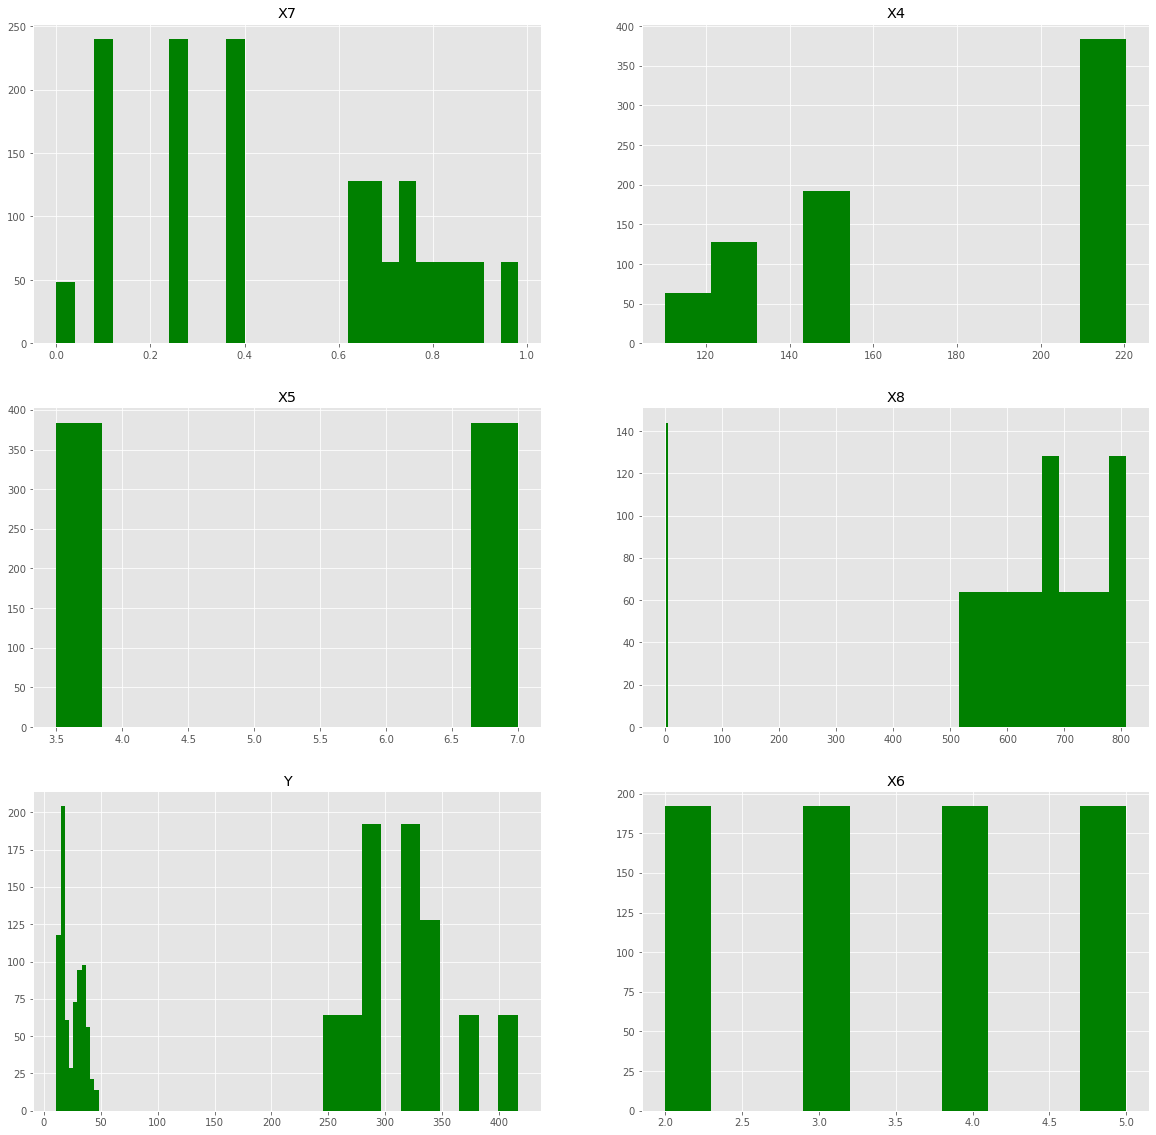

In [47]:
fig, ax = plt.subplots(figsize=(20,20), ncols=2, nrows=3)
i, j = 0, 0

# Visualizamos la distribución de variables por clases
for column in df_energy_efficiency:
    ax[i][j].set_title(column)
    ax[i][j].hist(df_energy_efficiency.loc[:, column], color='green')

    i = i + 1 if i < 2 else 0
    j = j + 1 if j < 1 else 0


Y también comprobamos la correlación entre variables:

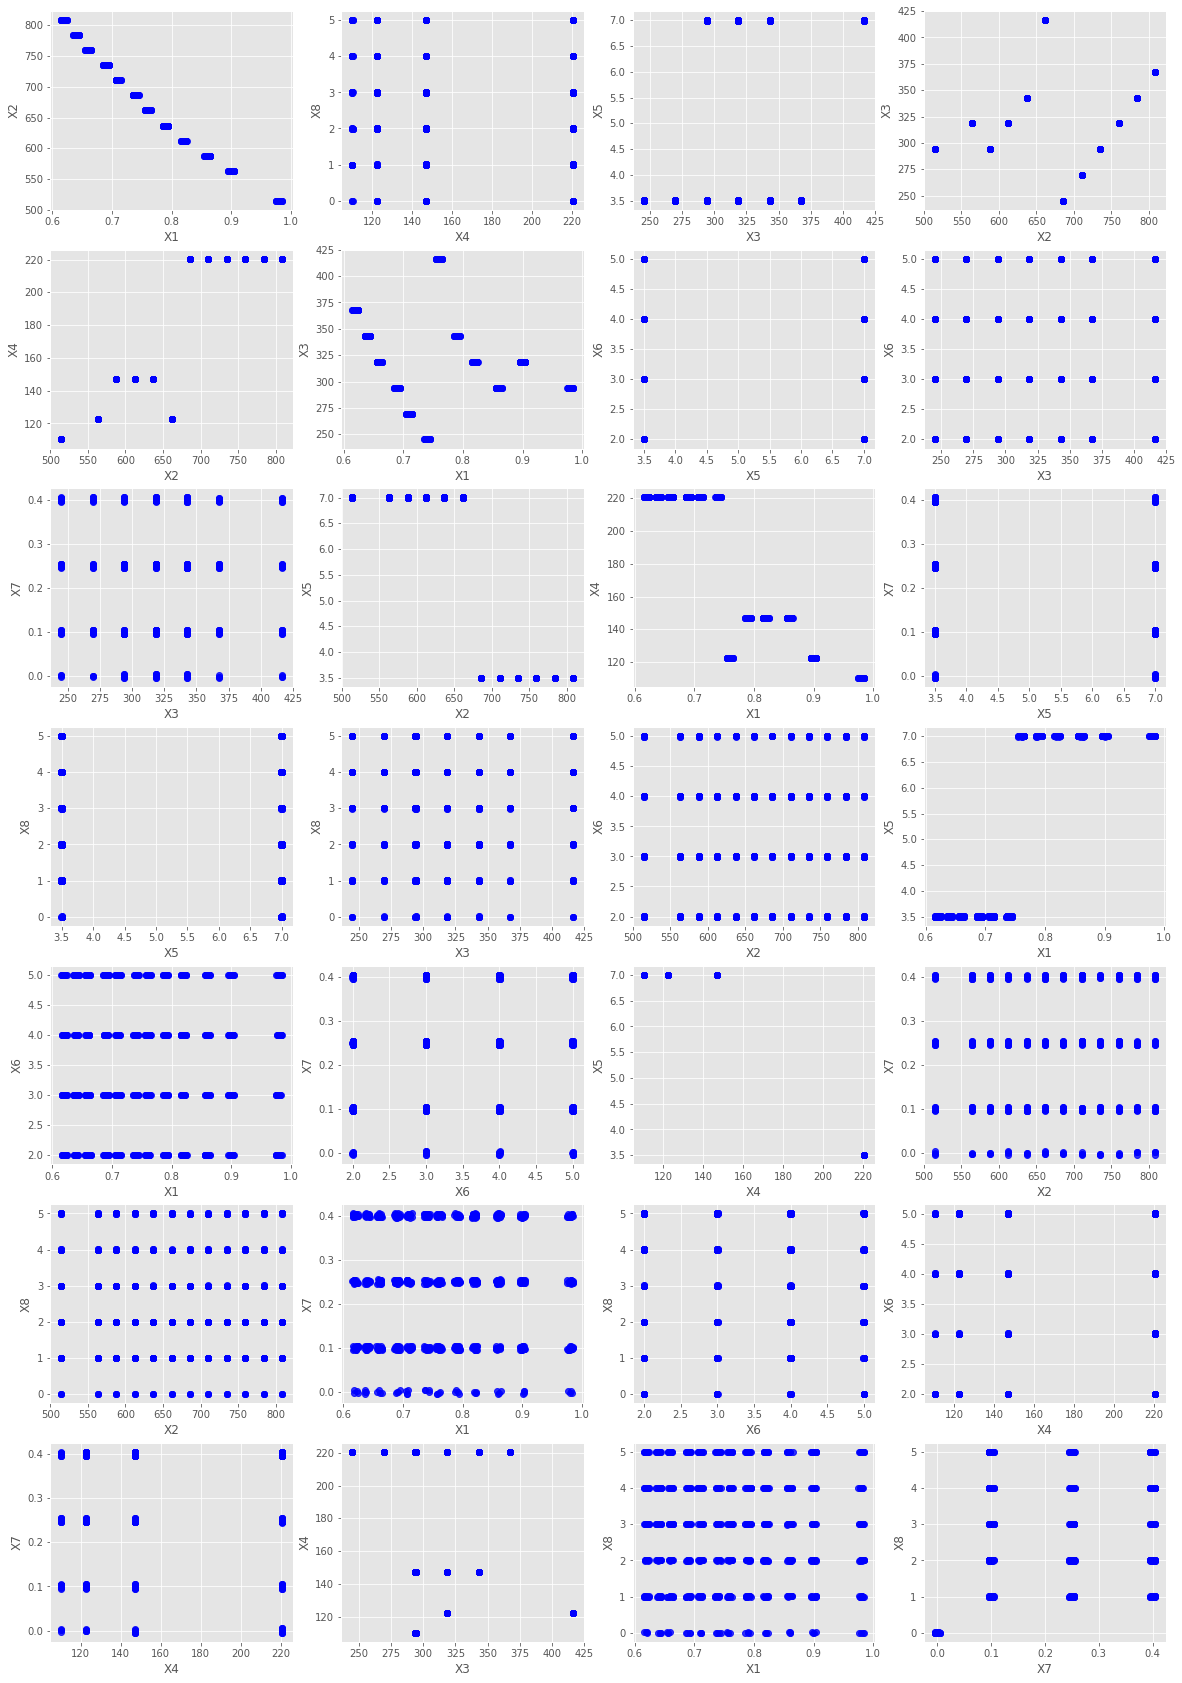

In [48]:
# Omitimos la variable dependiente
column_names = df_energy_efficiency.columns[:-1]

fig, ax = plt.subplots(figsize=(20, 30), nrows=7, ncols=4)
l, k = 0, 0

# Ahora representamos atributos por pares (mostrando también la clase)
for i, columna_i in enumerate(column_names):
    for j, columna_j in enumerate(column_names):
        if i < j:
            sb.regplot(data=df_energy_efficiency, 
                           x=columna_i, 
                           y=columna_j,
                           ax=ax[l][k],
                           color='b',
                           x_jitter=0.005,
                           y_jitter=0.005,
                           fit_reg=False)
            
            l = l + 1 if l < 6 else 0
            k = k + 1 if k < 3 else 0


### Apartado b

**Una de las clases que implementa el algoritmo KNN en `scikit‐learn` es `sklearn.neighbors.KNeighborsRegressor`. Revisa los parámetros y métodos que tiene.**

Se revisa la documentación de la clase `sklearn.neighbors.KNeighborsRegressor` para entender los parámetros que tiene, qué hace cada uno, y los métodos que tiene, y cuál es la función de cada uno.

### Apartado c

**Divide los datos en entrenamiento (80%) y test (20%).**

Dividimos los datos en entrenamiento (80%) y test (20%) mediante este comando:

In [49]:
df_energy_efficiency_train, df_energy_efficiency_test = train_test_split(
    df_energy_efficiency, 
    test_size=0.2, 
    random_state=SEED_VALUE)

Número de instancias en el conjunto de entrenamiento:

In [50]:
df_energy_efficiency_train.shape

(614, 9)

Número de instancias en el conjunto de test:

In [51]:
df_energy_efficiency_test.shape

(154, 9)

### Apartado d

**Realiza la experimentación con KNN (KNeighborsRegressor) usando como hiper‐parámetro el número de vecinos.**

Ahora llevamos a cabo la estandarización de los datos. Al ser un problema de **regresión** debemos estandarizar tanto los variables predictoras como la variable dependiente:

In [52]:
scaler = StandardScaler()
scaler.fit(df_energy_efficiency_train)
df_energy_efficiency_train_scaled = scaler.transform(df_energy_efficiency_train)
df_energy_efficiency_test_scaled = scaler.transform(df_energy_efficiency_test)


Los valores con los que se ha estandarizado son:

In [53]:
print(f"mean [X1, X2, X3, X4, X5, X6, X7, X8, Y]: {scaler.mean_}")
print(f"std [X1, X2, X3, X4, X5, X6, X7, X8, Y]: {scaler.scale_}")


mean [X1, X2, X3, X4, X5, X6, X7, X8, Y]: [7.62768730e-01 6.73191368e+02 3.18140879e+02 1.77525244e+02
 5.19869707e+00 3.47394137e+00 2.31921824e-01 2.83876221e+00
 2.43248697e+01]
std [X1, X2, X3, X4, X5, X6, X7, X8, Y]: [ 0.1069224  88.80609907 43.96132191 45.46444155  1.74924784  1.11918644
  0.13240652  1.54257571  9.45320583]


Volvemos a pasarlo a formato DataFrame:

In [54]:
df_energy_efficiency_train_scaled = pd.DataFrame(df_energy_efficiency_train_scaled,
                                                 columns=df_energy_efficiency_train.columns,
                                                 index=df_energy_efficiency_train.index)

df_energy_efficiency_test_scaled = pd.DataFrame(df_energy_efficiency_test_scaled,
                                                 columns=df_energy_efficiency_test.columns,
                                                 index=df_energy_efficiency_test.index)


En segundo lugar, dividimos en variables predictoras y dependientes:

In [55]:
df_energy_efficiency_train_X_scaled = df_energy_efficiency_train_scaled.loc[:, [
    'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].astype(float)
df_energy_efficiency_train_Y_scaled = df_energy_efficiency_train_scaled.loc[:, 'Y']

df_energy_efficiency_test_X_scaled = df_energy_efficiency_test_scaled.loc[:, [
    'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].astype(float)
df_energy_efficiency_test_Y_scaled = df_energy_efficiency_test_scaled.loc[:, 'Y']


Definimos los hiper-parámetros a usar:

In [56]:
hyperparameters = {'n_neighbors': range(1, 101, 1)}


Y ejecutamos el entrenamiento:

In [57]:
k_neigh = KNeighborsRegressor()
modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=5,
                       scoring="neg_mean_squared_error",
                       return_train_score=True)

# Por como funciona KNN, no haría falta establecer una semilla. Pero lo ponemos igualmente
np.random.seed(SEED_VALUE)

# En KNN no hay aprendizaje en sí, pero hay que ejecutar este comando para poder hacer inferencias
modelCV.fit(df_energy_efficiency_train_X_scaled, df_energy_efficiency_train_Y_scaled)


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 101)}, return_train_score=True,
             scoring='neg_mean_squared_error')

Observamos los resultados obtenidos:

In [58]:
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results['destandardized_mean_test_score'] = (-1) * cv_results['mean_test_score'] * (scaler.scale_[8]**2)
cv_results['destandardized_std_test_score'] = cv_results['std_test_score'] * (scaler.scale_[8]**2)

cv_results.loc[:, [
    'param_n_neighbors',
    'mean_test_score',
    'std_test_score',
    'destandardized_mean_test_score',
    'destandardized_std_test_score',
    'rank_test_score']
].sort_values(
    by="destandardized_mean_test_score"
)


,param_n_neighbors,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
1,2,-0.068429,0.006466,6.115019,0.577814,1
2,3,-0.075303,0.003949,6.729269,0.352912,2
3,4,-0.078041,0.006057,6.973982,0.541308,3
6,7,-0.083197,0.008479,7.434758,0.757746,4
5,6,-0.084842,0.005163,7.581701,0.461356,5
...,...,...,...,...,...,...
95,96,-0.128869,0.008504,11.516175,0.759911,96
96,97,-0.129391,0.008457,11.562758,0.755739,97
97,98,-0.129425,0.008429,11.565785,0.753234,98
98,99,-0.129950,0.008216,11.612736,0.734240,99


**Muestra la gráfica del error de entrenamiento con validación cruzada (5‐CV) frente al valor del hiper‐parámetro. ¿Cuál es el menor error de validación cruzada, su desviación estándar y el valor del hiper‐parámetro para el que se consigue? ¿Cuál es el valor del hiperparámetro si se aplicase la regla de una desviación estándar?**

Mostramos la gráfica con los resultados del entrenamiento:

<ErrorbarContainer object of 3 artists>

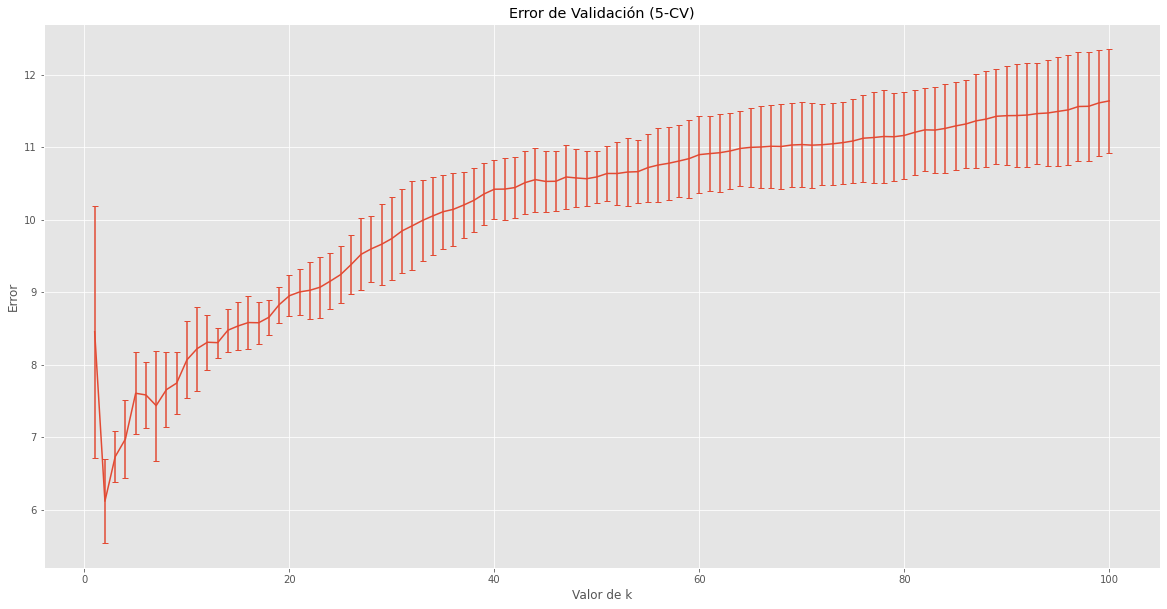

In [59]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de k")
ax.set_ylabel("Error")
ax.errorbar(cv_results['param_n_neighbors'],
            cv_results['destandardized_mean_test_score'],
            cv_results['destandardized_std_test_score'],
            label='destandardized',
            capsize=3)


El menor error de validación cruzada, su desviación estándar y el hiper-parámetro para el que se consigue es el siguiente:

In [71]:
cv_results_best = cv_results.sort_values(by='destandardized_mean_test_score')
cv_results_best.loc[:, [
    'param_n_neighbors',
    'mean_test_score',
    'std_test_score',
    'destandardized_mean_test_score',
    'destandardized_std_test_score',
    'rank_test_score'
    ]
].head(1)


,param_n_neighbors,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
1,2,-0.068429,0.006466,6.115019,0.577814,1


Si se aplicase la regla de la desviación estándar, el valor del hiperparámetro escogido sería el siguiente:

In [74]:
cv_results_best_error = float(
    cv_results_best.loc[1, 'destandardized_mean_test_score'])
cv_results_best_std = float(
    cv_results_best.loc[1, 'destandardized_std_test_score'])

cv_results_best_error_plus_std = cv_results_best_error + cv_results_best_std

cv_results_aux = cv_results[cv_results['destandardized_mean_test_score'] <=
                            cv_results_best_error_plus_std].sort_values(by='param_n_neighbors', ascending=False)

cv_results_aux = cv_results_aux.loc[:, [
    'param_n_neighbors',
    'mean_test_score',
    'std_test_score',
    'destandardized_mean_test_score',
    'destandardized_std_test_score',
    'rank_test_score'
    ]
]

cv_results_aux.head(1)


,param_n_neighbors,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
1,2,-0.068429,0.006466,6.115019,0.577814,1


Siendo la gráfica que usamos para decidir los valores de los hiper-parámetros (mediante la regla de una desviación estándar) la siguiente:

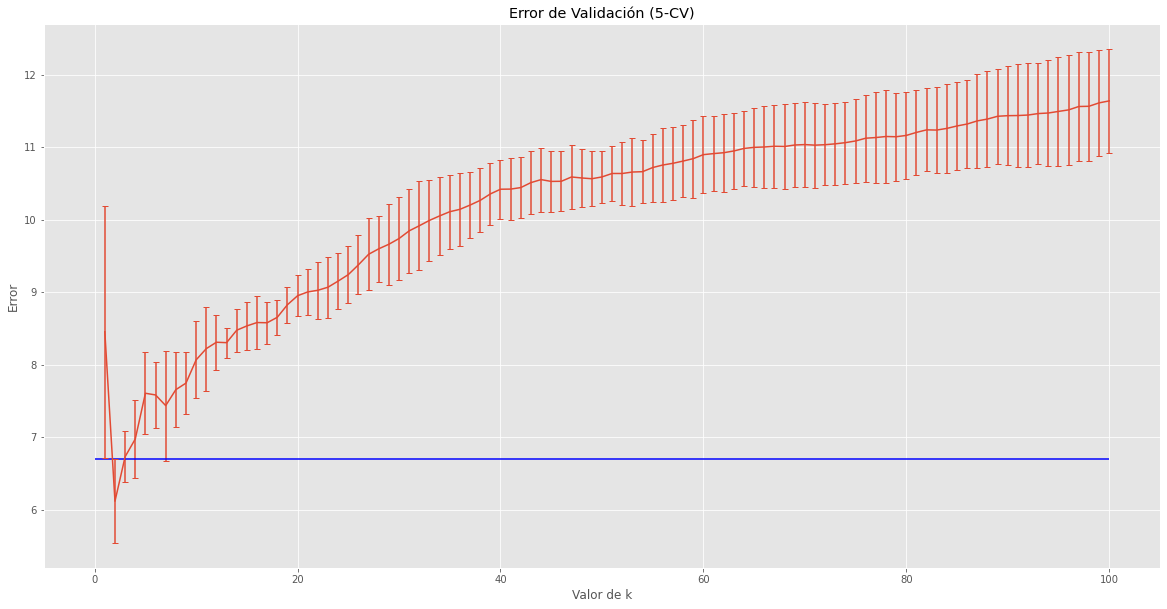

In [62]:
fig, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de k")
ax.set_ylabel("Error")
ax.errorbar(cv_results['param_n_neighbors'],
            cv_results['destandardized_mean_test_score'],
            cv_results['destandardized_std_test_score'],
            label='uniform', 
            capsize=3)
ax.hlines(y=cv_results_best_error_plus_std, xmin=0, xmax=100, colors='blue')


**Muestra la gráfica del error de test frente al valor del hiper‐parámetro, y valora si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test. ¿Cuál es el menor error de test y el valor del hiper‐parámetro para el que se consigue? ¿Cuál es el error de test para el valor del hiper‐parámetro seleccionado por la validación cruzada? ¿Cuál es el error de test para el valor del hiper‐parámetro seleccionado por la validación cruzada mediante la regla de una desviación estándar?**

En primer lugar, debemos calcular el error de test frente al valor del hiper-parámetro:

In [63]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(df_energy_efficiency_train_Y_scaled) + [0]*len(df_energy_efficiency_test_Y_scaled)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_energy_efficiency_all_X_scaled = np.vstack(
    [df_energy_efficiency_train_X_scaled, df_energy_efficiency_test_X_scaled])
df_energy_efficiency_all_Y_scaled = np.hstack(
    [df_energy_efficiency_train_Y_scaled, df_energy_efficiency_test_Y_scaled])

k_neigh = KNeighborsRegressor()
modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=ps,
                       scoring='neg_mean_squared_error',
                       return_train_score=True,
                       n_jobs=-1)

# Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
np.random.seed(SEED_VALUE)
modelCV.fit(df_energy_efficiency_all_X_scaled, df_energy_efficiency_all_Y_scaled)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 101)}, return_train_score=True,
             scoring='neg_mean_squared_error')

Mostramos el resultado por pantalla:

In [64]:
test_results = pd.DataFrame(modelCV.cv_results_)
test_results['destandardized_mean_test_score'] = -test_results['mean_test_score'] * (scaler.scale_[8]**2)
test_results['destandardized_std_test_score'] = test_results['std_test_score'] * (scaler.scale_[8]**2)

test_results.loc[:, [
    'param_n_neighbors',
    'mean_test_score',
    'std_test_score',               
    'destandardized_mean_test_score',
    'destandardized_std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by="rank_test_score"
)


,param_n_neighbors,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
8,9,-0.107463,0.0,9.603207,0.0,1
7,8,-0.107991,0.0,9.650452,0.0,2
6,7,-0.108821,0.0,9.724561,0.0,3
9,10,-0.109666,0.0,9.800067,0.0,4
12,13,-0.110855,0.0,9.906309,0.0,5
...,...,...,...,...,...,...
86,87,-0.168189,0.0,15.029877,0.0,96
87,88,-0.168335,0.0,15.042939,0.0,97
88,89,-0.168402,0.0,15.048902,0.0,98
99,100,-0.168565,0.0,15.063454,0.0,99


<ErrorbarContainer object of 3 artists>

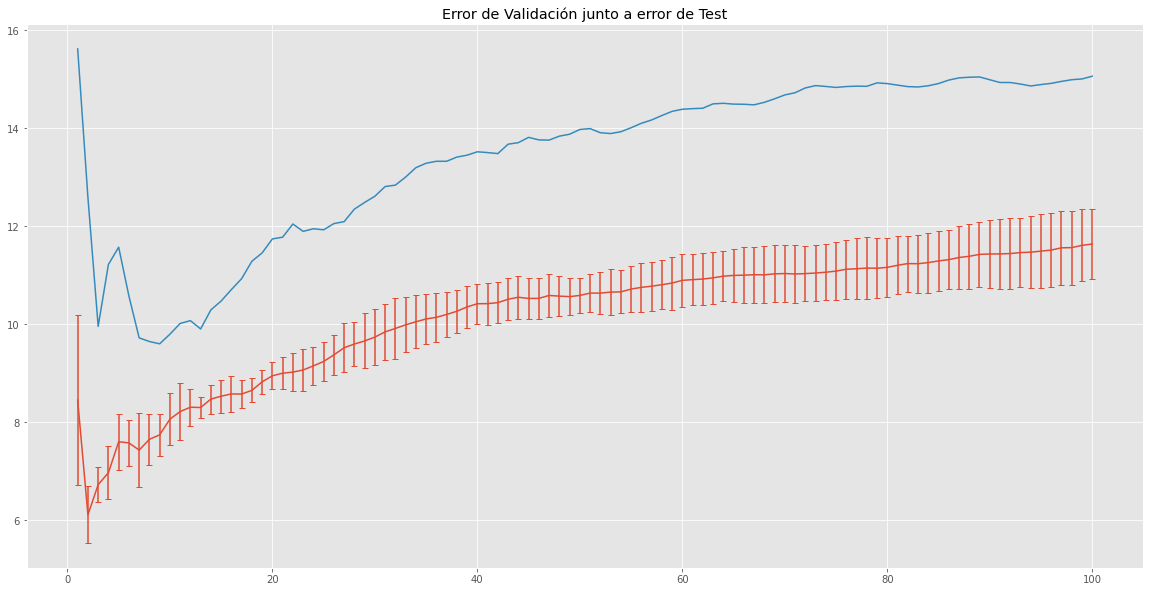

In [65]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Error de Validación junto a error de Test")
ax.errorbar(cv_results['param_n_neighbors'],
               cv_results['destandardized_mean_test_score'],
               cv_results['destandardized_std_test_score'],
               label='validation (uniform)',
               capsize=3)
ax.errorbar(test_results['param_n_neighbors'],
               test_results['destandardized_mean_test_score'],
               label='test (uniform)',
               capsize=3)


En este caso en error de entrenamiento aproxima de una manera más optimista que el error de test.

El menor error de test se consigue para los siguientes valores de los hiper-parámetros:

In [66]:
test_results_best = test_results.sort_values(by='destandardized_mean_test_score')
test_results_best.loc[:, [
    'param_n_neighbors',
    'mean_test_score', 
    'std_test_score', 
    'destandardized_mean_test_score', 
    'destandardized_std_test_score', 
    'rank_test_score'
    ]
].head(1)

,param_n_neighbors,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
8,9,-0.107463,0.0,9.603207,0.0,1


Siendo el error correspondiente:

In [67]:
test_results_best_error = float(test_results_best.loc[8, 'destandardized_mean_test_score'])
test_results_best_error


9.603206581689916

El error de test para el valor seleccionado por la validación cruzada es:

In [68]:
test_results_cv_error = float(test_results_best.loc[1, 'destandardized_mean_test_score'])
test_results_cv_error


12.588656331168831

Y para los valores seleccionados mediante la regla de una desviación estándar:

In [75]:
test_results_cv_std_error = float(test_results_best.loc[1, 'destandardized_mean_test_score'])
test_results_cv_std_error


12.588656331168831